In [1]:
!pip install datasketch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from scipy.cluster.vq import kmeans2, vq
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

import time


In [4]:
def PQ_train(vectors, M, k):
    s = int(vectors.shape[1] / M)                      # Dimension of segments.
    codebook = np.empty((M, k, s), np.float32)         
        
    for m in range(M):
        sub_vectors = vectors[:, m*s:(m+1)*s]          # Sub-vectors for segment m.
        codebook[m], label = kmeans2(sub_vectors, k)   # k-means for each subspace.
        
    return codebook

In [5]:
def PQ_encode(vectors, codebook):
    M, k, s = codebook.shape
    PQ_code = np.empty((vectors.shape[0], M), np.uint8)
    
    for m in range(M):
        sub_vectors = vectors[:, m*s:(m+1)*s]           # Sub-vectors for segment m.
        centroid_ids, _ = vq(sub_vectors, codebook[m])  # vq returns the nearest centroid Ids.
        PQ_code[:, m] = centroid_ids                    # Assign centroid Ids to PQ_code.
        
    return PQ_code

In [6]:
def PQ_search(query_vector, codebook, PQ_code):
    M, k, s = codebook.shape


    # Build the distance table
    
    distance_table = np.empty((M, k), np.float32)
        
    for m in range(M):
        query_segment = query_vector[m*s:(m+1)*s]    # Query vector for segment m.
        distance_table[m] = cdist([query_segment], codebook[m], "sqeuclidean")[0]
        
    
    N, M = PQ_code.shape
    distance_table = distance_table.T               
    distances = np.zeros((N, )).astype(np.float32)

    for n in range(N):                              # For each PQ Code, lookup partial distances.
        for m in range(M):
            distances[n] += distance_table[PQ_code[n][m]][m] # Sum the partial distances from all the segments.
            
    return distance_table, distances

In [7]:
# Test case
  
M = 8                     # Number of segments
# k = 256                   # Number of centroids per segment
k = 64                   # Number of centroids per segment
vector_dim = 128          # Dimension (length) of a vector
# total_vectors = 1000000   # Number of database vectors
total_vectors = 1000   # Number of database vectors


# Generate random vectors
np.random.seed(2022)
vectors = np.random.random((total_vectors, vector_dim)).astype(np.float32)   # Database vectors
vector_norms=np.linalg.norm(vectors)
norm_vectors=vectors/vector_norms
q = np.random.random((vector_dim, )).astype(np.float32)                      # Query vector


In [8]:
# Train, encode and search with Product Quantization
codebook = PQ_train(norm_vectors, M, k)
PQ_code = PQ_encode(norm_vectors, codebook)
distance_table, distances = PQ_search(q, codebook, PQ_code)
# All the distances are returned

/usr/local/lib/python3.10/dist-packages/scipy/cluster/vq.py:602: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [9]:
print(PQ_code.shape)
print(distance_table.shape)
print(distances.shape)
print(codebook.shape)

(1000, 8)
(64, 8)
(1000,)
(8, 64, 16)


In [10]:
import numpy as np
import itertools
import collections

def cossim(u,v):
    norm = np.linalg.norm(u)*np.linalg.norm(v)
    cosine = u@v/norm
    ang = np.arccos(cosine)
    return 1-ang/np.pi

def lsh_precompute(A, b, r, thresh):
  """ A must be an (N,D) matrix consisting of N real valued euclidean vectors.
  Args:
    A: the (N,D) matrix of vectors to with which to find similar pairs
    b: the number of bands
    r: the number of rows per band
    thresh: a float value [-1,1] determining the required cosine similarity threshold
  """
  N, D = A.shape
  n = b*r
  
  # Compute signature matrix
  R = A@np.random.randn(D, n)
  S = np.where(R>0, 1, 0)

  # Break into bands
  S = np.split(S, b, axis=1)

  # column vector to convert binary vector to integer e.g. (1,0,1)->5
  binary_column = 2**np.arange(r).reshape(-1,  1)

  # convert each band into a single integer, 
  # i.e. convert band matrices to band columns
  S = np.hstack([M@binary_column for M in S])

  # Every value in the matrix represents a hash bucket assignment
  # For every bucket in row i, add index i to that bucket
  d = collections.defaultdict(set)
  with np.nditer(S,flags=['multi_index']) as it:
      for x in it:
          d[int(x)].add(it.multi_index[0])

  # # For every bucket, find all pairs. These are the LSH pairs.
  # candidate_pairs = set()
  # for k,v in d.items():
  #     if len(v) > 1:
  #         for pair in itertools.combinations(v, 2):
  #             candidate_pairs.add(tuple(sorted(pair)))

  # # Finally, perform the actually similarity computation
  # # to weed out false positives
  # lsh_pairs = set()
  # for (i, j) in candidate_pairs:
  #     if cossim(A[i],A[j]) > thresh:
  #         lsh_pairs.add((i, j))
          
  # return lsh_pairs

  return d

In [11]:
hash_table=lsh_precompute(vectors,4,8, 0.5)

In [12]:
# print(len(hash_table))
# print(hash_table[0])

In [14]:
def lsh_query(d, query, b, r, th):
  
  N, D = query.shape
  # N, D = 1, len(query)
  n = b*r
  
  # Compute signature matrix
  R = query@np.random.randn(D, n)
  S = np.where(R>0, 1, 0)

  # Break into bands
  S = np.split(S, b, axis=1)

  # column vector to convert binary vector to integer e.g. (1,0,1)->5
  binary_column = 2**np.arange(r).reshape(-1,  1)

  # convert each band into a single integer, 
  # i.e. convert band matrices to band columns
  S = np.hstack([M@binary_column for M in S])

  l=[]
  d = collections.defaultdict(set)
  with np.nditer(S,flags=['multi_index']) as it:
      for x in it:
          l.append(int(x))
          # d[int(x)].add(it.multi_index[0])
  return l

In [15]:
q = np.random.random((vector_dim, )).astype(np.float32)
candidate_buckets=lsh_query(hash_table, np.expand_dims(q, axis=0), 4, 8 , 0.5)

In [16]:
candidates=set()
for b in candidate_buckets:
  for e in hash_table[b]:
    candidates.add(e)

candidates=list(candidates)

In [17]:
len(candidates) 

152

In [18]:
def NN_search(query_vector, codebook, PQ_code):
    M, k, s = codebook.shape

    # Build the distance table
        
    distance_table = np.empty((M, k), np.float32)    
        
    for m in range(M):
        query_segment = query_vector[m*s:(m+1)*s]    # Query vector for segment m.
        distance_table[m] = cdist([query_segment], codebook[m], "sqeuclidean")[0]
        
    
    N, M = PQ_code.shape
    distance_table = distance_table.T   
    # distances = np.zeros((N, )).astype(np.float32)

    candidate_buckets=lsh_query(hash_table, np.expand_dims(query_vector, axis=0), 4, 8 , 0.5)
    candidates=set()
    for b in candidate_buckets:
      for e in hash_table[b]:
        candidates.add(e)

    candidates=list(candidates)

    distances = np.zeros((len(candidates), )).astype(np.float32)
    min_dist=np.inf
    nearest_neighbor=-1
    for i in range(len(candidates)):                              # For each PQ Code, lookup the partial distances.
        for m in range(M):
            distances[i] += distance_table[PQ_code[i][m]][m] # Sum the partial distances from all the segments.
        if distances[i]< min_dist:
            min_dist=distances[i]
            nearest_neighbor=i
            
    return distances, min_dist, len(candidates)

In [19]:
nn_distance, min_dist, candidate_size= NN_search(q, codebook, PQ_code)

In [20]:
# nn_distance
# print(min_dist, n_neighbor)

# print(candidates[234])
# print(nn_distance[:10])
# print(nn_distance[234])

#Performance


In [21]:
queries=[np.random.random((vector_dim, )).astype(np.float32) for i in range(50)] #generate 50 query vectors

In [22]:
time1,time2=[],[]
res1, res2=[],[]
search_size=[]
for i in range(len(queries)):
  start_t1=time.time()
  nn_distances, min_dist, candidate_size= NN_search(queries[i], codebook, PQ_code)
  res1.append(min_dist)
  search_size.append(candidate_size)
  end_t1=time.time()
  time1.append(end_t1-start_t1)
  start_t2=time.time()
  distance_table, distances= PQ_search(queries[i], codebook, PQ_code)
  mn_distance=min(distances)
  res2.append(mn_distance)
  end_t2=time.time()
  time2.append(end_t2-start_t2)


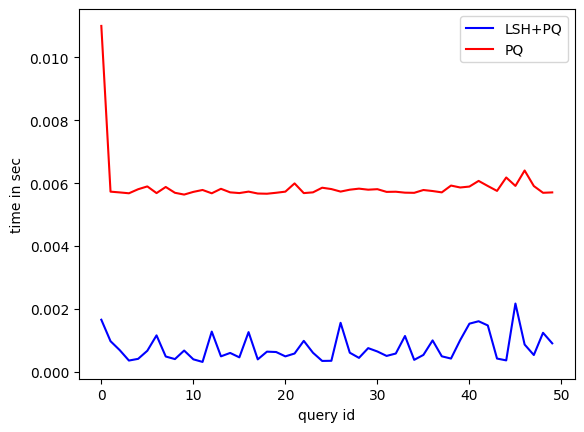

In [30]:
def plot_time():
  plt.plot([i for i in range(50)],time1, color='b')
  plt.plot([i for i in range(50)],time2, color='r')
  plt.xlabel('query id')
  plt.ylabel('time in sec')
  plt.legend(['LSH+PQ','PQ' ])
  plt.show()

plot_time()

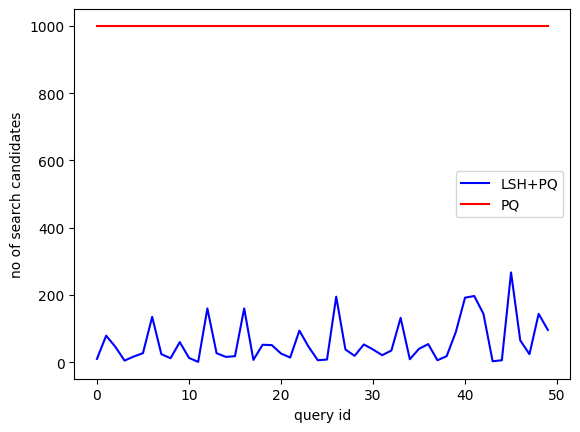

In [32]:
def plot_search_size():
  plt.plot([i for i in range(50)],search_size, color='b')
  plt.plot([i for i in range(50)],[len(vectors)]*50, color='r')
  plt.xlabel('query id')
  plt.ylabel('no of search candidates')
  plt.legend(['LSH+PQ','PQ' ])
  plt.show()

plot_search_size()

<ipython-input-38-300dff4ccb6e>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--b" (-> color='b'). The keyword argument will take precedence.
  plt.plot([i for i in range(50)],res2, '--b', color='r')


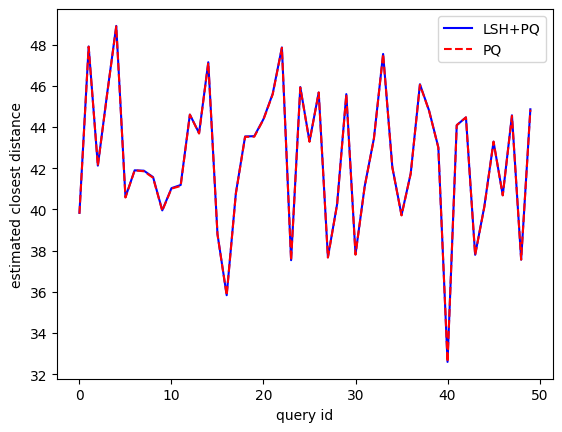

In [38]:
def plot_res():
  plt.plot([i for i in range(50)],res1, color='b')
  plt.plot([i for i in range(50)],res2, '--b', color='r')
  plt.xlabel('query id')
  plt.ylabel('estimated closest distance')
  plt.legend(['LSH+PQ','PQ' ])
  plt.show()
plot_res()